In [1]:
# ¡¡¡ Conectar con Google Drive !!!

# Se cambia al directorio donde esté el notebook con las clases a importar
%cd "/content/drive/MyDrive/Colab_Notebooks/ESRGAN"

# Se instala e importa import_ipynb para poder acceder a clases/funciones de otros notebooks
!pip install -q import-ipynb
!pip install -q torchmetrics    # Paquete de métricas


/content/drive/MyDrive/Colab_Notebooks/ESRGAN
     |████████████████████████████████| 282 kB 5.3 MB/s 


# Configuración

In [2]:
# Manejo y representación de datos
#import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from tqdm import tqdm

# Pytorch 
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, MultiStepLR

# Dataset y Dataloader
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Transformaciones
import albumentations as A

# Modelos y clases
import import_ipynb
#from models import Generator, Discriminator, ContentLoss
# from models import Generator, Discriminator, FeatureExtractor
from dataset import *
from model import *
from train import *



importing Jupyter notebook from dataset.ipynb
importing Jupyter notebook from model.ipynb
importing Jupyter notebook from train.ipynb


In [3]:
# ------------------------------------------------------------------------------
# ------------ Configuración general  ------------------------------------------
# ------------------------------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_imagenes = 500     # Número de imaganes empleadas
bs         = 4      # Tamaño del batch
p_epochs   = 8      # Número de epocas de entrenamiento del generador
epochs     = 4      # Número de epocas de entrenamiento adversarial


# ------------------------------------------------------------------------------
# ------------ DataFrame -------------------------------------------------------
# ------------------------------------------------------------------------------
# Carpeta que contiene las imágenes
img_fol= '/content/drive/MyDrive/Colab_Notebooks/carvana/train/' 

# Dataframe de n_imagenes
df = pd.DataFrame(os.listdir(img_fol), columns = ['name']) 
df = df.iloc[:n_imagenes]  
  
# Se divide el dataframe en entrenamiento y validación 
df_train, df_val = train_test_split(df, test_size=.2, random_state=42, shuffle=True, stratify=None) 

# Se resetan los índices
df_train  = df_train.reset_index()  # DataFrame de entrenamiento
df_val    = df_val.reset_index()    # DataFrame de validación


# ------------------------------------------------------------------------------
# ------------ Transformaciones ------------------------------------------------
# ------------------------------------------------------------------------------
transforms = A.Compose([
            A.Resize(256, 256),
            A.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
        ])


# ------------------------------------------------------------------------------
# ------------ Datasets y dataloaders ------------------------------------------
# ------------------------------------------------------------------------------

# Datasets de entrenamiento y evaluación
carDatasetTrain = CarDataset(df=df_train, transforms=transforms)
carDatasetval   = CarDataset(df=df_val, transforms=transforms)

# Dataloaders de entrenamiento y evaluación
train_dataloader  = DataLoader(carDatasetTrain, batch_size=bs,
                                shuffle=True, num_workers=0)
val_dataloader    = DataLoader(carDatasetval, batch_size=bs,
                                shuffle=False, num_workers=0) # val_dataloader sin shuffle


# ------------------------------------------------------------------------------
# ------------ Entrenamiento y validación --------------------------------------
# ------------------------------------------------------------------------------

# Se instancian los modelos y se envían a la gpu si está disponible
generator       = Generator().to(device)      # Generador
discriminator   = Discriminator().to(device)  # Discriminador


# Funciones de pérdida
pixel_criterion       = nn.L1Loss().to(device)
content_criterion     = ContentLoss().to(device)
adversarial_criterion = nn.BCELoss().to(device)   # Adversarial loss.

# Optimizers
optimizer_P = optim.Adam(generator.parameters(), lr=0.0001)     # LR generador durante entrenamiento del generador
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001) # LR discriminador durante entrenamiento adversarial
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001)     # LR generador durante entrenamiento adversarial

# Schedulers
milestones  = [epochs * 0.125, epochs * 0.250, epochs * 0.500, epochs * 0.750]
scheduler_P = CosineAnnealingLR(optimizer_P, p_epochs // 4, 1e-7)               # Generator model scheduler during generator training.
scheduler_D = MultiStepLR(optimizer_D, list(map(int, milestones)), 0.5)         # Discriminator model scheduler during adversarial training.
scheduler_G = MultiStepLR(optimizer_G, list(map(int, milestones)), 0.5)         # Generator model scheduler during adversarial training.


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [4]:
# Se inicializan listas vacias en las que se almacenarán lás metricas para cada epoch

tg_pixel_loss, tg_psnr, tg_ssim, tg_rmse = [], [], [], []          # Métricas entrenamiento generador
vg_psnr, vg_ssim, vg_rmse = [], [], []                             # Métricas validación generador

ta_gloss, ta_dloss, ta_psnr, ta_ssim, ta_rmse = [], [], [], [], [] # Métricas entrenamiento adversarial
va_psnr, va_ssim, va_rmse = [], [], []                             # Métricas validación adversarial

# Entrenamiento y validación del generador
if os.path.exists('/content/drive/MyDrive/Colab_Notebooks/ESRGAN/saved_models/p-best.pth'):
    generator.load_state_dict(torch.load('/content/drive/MyDrive/Colab_Notebooks/ESRGAN/saved_models/p-best.pth', map_location=torch.device(device))) # Se cargan los pesos del modelo

for epoch in range(p_epochs) :

    # Entrenamiento
    with tqdm(train_dataloader,unit='batch') as tloader : 
        tg_scores = train_generator(epoch, p_epochs, tloader, generator, pixel_criterion, optimizer_P,device)
        
        tg_pixel_loss.append(tg_scores[0])
        tg_psnr.append(tg_scores[1])
        tg_ssim.append(tg_scores[2])
        tg_rmse.append(tg_scores[3])

    # Validación
    with tqdm(val_dataloader,unit='batch') as vloader : 
        vg_scores = validate(epoch,p_epochs,vloader,"GENERATOR",generator,device,bs)

        vg_psnr.append(vg_scores[0])
        vg_ssim.append(vg_scores[1])
        vg_rmse.append(vg_scores[2])

        if epoch == 0:
            best_psnr_value = 0  
        is_best = vg_psnr[epoch] > best_psnr_value
        best_psnr_value = max(vg_psnr[epoch], best_psnr_value)
        if is_best:
            torch.save(generator.state_dict(), "/content/drive/MyDrive/Colab_Notebooks/ESRGAN/saved_models/p-best.pth")
    
    scheduler_P.step()

# Entrenamiento y validación adversarial
generator.load_state_dict(torch.load("/content/drive/MyDrive/Colab_Notebooks/ESRGAN/saved_models/p-best.pth", map_location=torch.device(device)))
if os.path.exists('/content/drive/MyDrive/Colab_Notebooks/ESRGAN/saved_models/d-best.pth'):
    discriminator.load_state_dict(torch.load('/content/drive/MyDrive/Colab_Notebooks/ESRGAN/saved_models/d-best.pth', map_location=torch.device(device))) # Se cargan los pesos del modelo

for epoch in range(epochs) :

    # Entrenamiento adversarial
    with tqdm(train_dataloader,unit='batch') as tloader : 

        ta_scores = train_adversarial(epoch, epochs, tloader, generator, optimizer_G, discriminator, optimizer_D, adversarial_criterion, pixel_criterion, content_criterion, device)

        # Se almacenan las métricas en las listas correspondientes
        ta_gloss.append(ta_scores[0])
        ta_dloss.append(ta_scores[1])
        ta_psnr.append(ta_scores[2])
        ta_ssim.append(ta_scores[3])
        ta_rmse.append(ta_scores[4])



    # Validación adversarial
    with tqdm(val_dataloader,unit='batch') as vloader : 
        va_scores = validate(epoch,epochs,vloader,"ADVERSARIAL",generator,device,bs)
        # Se almacenan las métricas en las listas correspondientes
        va_psnr.append(va_scores[0])
        va_ssim.append(va_scores[1])
        va_rmse.append(va_scores[2])

        if epoch == 0:
            best_psnr_value = 0  
        is_best = va_psnr[epoch] > best_psnr_value
        best_psnr_value = max(va_psnr[epoch], best_psnr_value)
        if is_best:
            torch.save(discriminator.state_dict(), "/content/drive/MyDrive/Colab_Notebooks/ESRGAN/saved_models/d-best.pth")
            torch.save(generator.state_dict(), "/content/drive/MyDrive/Colab_Notebooks/ESRGAN/saved_models/g-best.pth")
    scheduler_D.step()
    scheduler_G.step() 
     



Output hidden; open in https://colab.research.google.com to view.

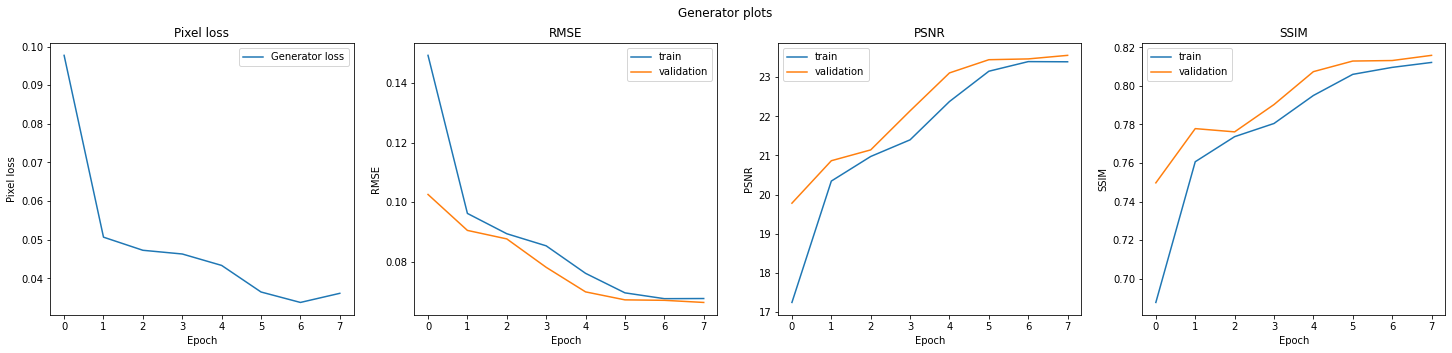

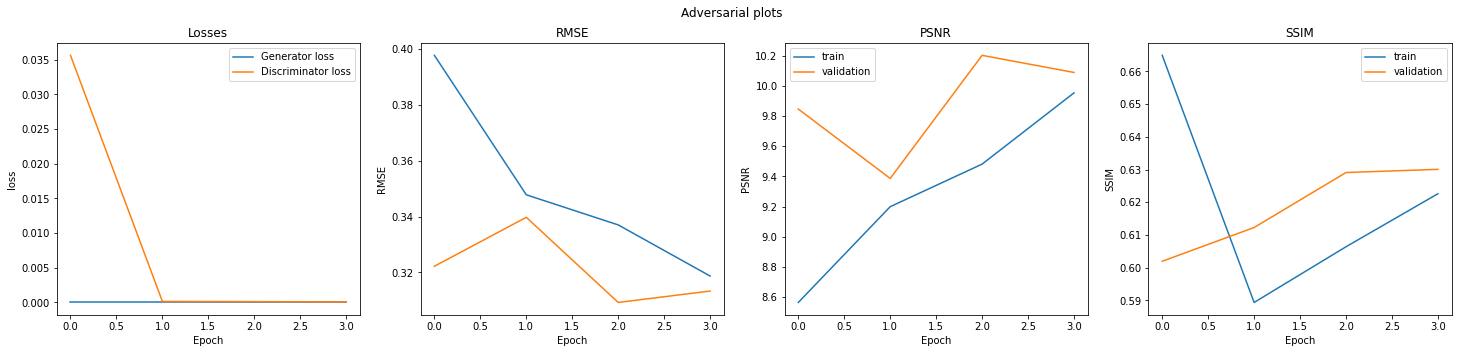

In [5]:
# Generator plots
plt.figure(figsize=(25,5))
plt.suptitle("Generator plots")

plt.subplot(1,4,1)
plt.title(f"Pixel loss")
plt.xlabel('Epoch')
plt.ylabel('Pixel loss')
plt.plot(tg_pixel_loss, label='Generator loss')
plt.legend()

plt.subplot(1,4,2)
plt.title(f"RMSE")
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.plot(tg_rmse, label='train')
plt.plot(vg_rmse, label='validation')
plt.legend()

plt.subplot(1,4,3)
plt.title(f"PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.plot(tg_psnr, label='train')
plt.plot(vg_psnr, label='validation')
plt.legend()

plt.subplot(1,4,4)
plt.title(f"SSIM")
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.plot(tg_ssim, label='train')
plt.plot(vg_ssim, label='validation')
plt.legend()



# Adversarial plots
plt.figure(figsize=(25,5))
plt.suptitle("Adversarial plots")

plt.subplot(1,4,1)
plt.title(f"Losses")
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.plot(ta_gloss, label='Generator loss')
plt.plot(ta_dloss, label='Discriminator loss')
plt.legend()

plt.subplot(1,4,2)
plt.title(f"RMSE")
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.plot(ta_rmse, label='train')
plt.plot(va_rmse, label='validation')

plt.subplot(1,4,3)
plt.title(f"PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.plot(ta_psnr, label='train')
plt.plot(va_psnr, label='validation')
plt.legend()

plt.subplot(1,4,4)
plt.title(f"SSIM")
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.plot(ta_ssim, label='train')
plt.plot(va_ssim, label='validation')
plt.legend()
